# RGR Stock Price Forecasting Project - Part 7

Author: Jack Wang

---

## Problem Statement

Stock prices are hard to predict because they are not only affected by the performance of the underlying companies but also the expectations from the general public. As known, the stock price of firearm companies are highly correlated to the public opinions toward gun control. My model intends to predict the stock price of one of the largest firearm company in the states, RGR (Sturm, Ruger & Co., firearm company), by using its historical stock price, public opinions toward gun control, and its financial reports to SEC. 

## Executive Summary

The goal of my project is to build a **time series regression model** that predicts the stock price of RGR. The data I am using would be historical stock price from [Yahoo Finance](https://finance.yahoo.com/quote/RGR/history?p=RGR), twitter posts scraped from [twitter](https://twitter.com/), subreddit posts mentioned about gun control, and also the financial reports to [SEC](https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000095029&type=&dateb=&owner=exclude&count=100). I will do sentiment analysis on the text data and time series modeling on the historical stock price data. The model will be evaluated using MSE.

## Content

This project consists of 7 Jupyter notebooks:
- Part-1-stock-price-data
- Part-2-twitter-scraper
- Part-3-twitter-data-cleaning
- Part-4-reddit-data-scraper
- Part-5-reddit-data-cleaning
- Part-6-sec-data-cleaning
- ***Part-7-modeling-and-evaluation***
    - [Final Dataframe Preparation](#Final-Dataframe-Preparation)
    - [Dictionary](#Dictionary)
    - [SARIMAX Model](#SARIMAX-Model)
    - [SARIMAX with Less Features](#SARIMAX-with-Less-Features)
    - [SARIMAX on Percentage Difference](#SARIMAX-on-Percentage-Difference)
    - [Neural Network - RNN Classifier](#Neural-Network---RNN-Classifier)
    - [Neural Network - RNN Regressor](#Neural-Network---RNN-Regressor)
    - [Final RNN Classifier Model for Flask](#Final-RNN-Classifier-Model-for-Flask)
    - [Conclusion](#Conclusion)
    - [Improvements](#Improvements)
    - [References](#References)

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model

%matplotlib inline

plt.style.use('fivethirtyeight')

/Users/jackwang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Final Dataframe Preparation

In [2]:
df_twitter = pd.read_csv("../data/twitter/twitter.csv")
df_reddit = pd.read_csv("../data/reddit/reddit.csv")
df_sec = pd.read_csv("../data/sec/sec_data.csv")
df_rgr = pd.read_csv("../data/stock_price/stock_price_2014_to_2019.csv")

In [3]:
# Format RGR dataset
df_rgr = df_rgr.loc[:,['Date', 'Open']]
df_rgr.columns = ['date', 'open_price']
df_rgr = df_rgr.iloc[693:1446].reset_index(drop=True)

# Merge all dataset
df_final = pd.merge(df_rgr, df_twitter, how='outer')
df_final = pd.merge(df_final, df_reddit, how = 'outer')
df_final = pd.merge(df_final, df_sec, how = 'outer' )

# Formatting and filling N/A
df_final['date'] = pd.to_datetime(df_final['date'])
df_final = df_final.set_index('date')
df_final = df_final.sort_index()
df_final = df_final.fillna(0)
df_final = df_final[df_final['open_price']!=0]

df_final.head()

,open_price,tweet_word_count_sum,tweet_compound_score_sum,tweets_sum,tweet_word_count_mean,tweet_compound_score_mean,redd_gun_score_mean,redd_gun_comment_mean,redd_gun_compound_mean,redd_gun_score_sum,...,redd_gun_post_count,redd_pol_score_mean,redd_pol_comment_mean,redd_pol_compound_mean,redd_pol_score_sum,redd_pol_comment_sum,redd_pol_post_count,10-k,10-q,8-k
date,,,,,,,,,,,,,,,,,,,,,
2016-10-03,57.790001,18548,-401.5402,1133,16.370697,-0.354404,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-04,57.470001,16554,-356.2059,1017,16.277286,-0.350252,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-05,57.330002,19727,-338.7394,1194,16.521776,-0.283701,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-06,56.400002,12924,-220.6480,807,16.014870,-0.273418,0.0,7.0,-0.7184,0.0,...,1.0,2.0,5.0,-0.1958,4.0,10.0,2.0,0.0,0.0,0.0
2016-10-07,56.020000,9767,-210.2939,613,15.933116,-0.343057,1.0,1.0,-0.1280,1.0,...,1.0,0.0,3.0,0.3612,0.0,3.0,1.0,0.0,0.0,0.0


In [4]:
# Export to csv
df_final.to_csv("../data/final.csv",index=False)

In [5]:
df_final.dtypes

open_price                   float64
tweet_word_count_sum           int64
tweet_compound_score_sum     float64
tweets_sum                     int64
tweet_word_count_mean        float64
tweet_compound_score_mean    float64
redd_gun_score_mean          float64
redd_gun_comment_mean        float64
redd_gun_compound_mean       float64
redd_gun_score_sum           float64
redd_gun_comment_sum         float64
redd_gun_post_count          float64
redd_pol_score_mean          float64
redd_pol_comment_mean        float64
redd_pol_compound_mean       float64
redd_pol_score_sum           float64
redd_pol_comment_sum         float64
redd_pol_post_count          float64
10-k                         float64
10-q                         float64
8-k                          float64
dtype: object

### Dictionary

|Column Name|Type|Data Collected|Description|
|:--|:--|:--|:--|
|open_price|float64|Yahoo Finance|The open stock price for the given trade day|
|tweet_word_count_sum|int64|Twitter|The total number of word counts of all tweets mentioning about gun control for the given date|
|tweet_compound_score_sum|float64|Twitter|The total compound score (sentiment) of all tweets mentioning about gun control for the given date|
|tweets_sum|int64|Twitter|The total counts of all tweets mentioning about gun control for the given date|
|tweet_word_count_mean|float64|Twitter|The mean of word counts of all tweets mentioning about gun control for the given date|
|tweet_compound_score_mean|float64|Twitter|The compound score mean of all tweets mentioning about gun control for the given date|
|redd_gun_score_mean|float64|/guns subreddit|The subreddit score mean of all the threads on /guns for the given date|
|redd_gun_comment_mean|float64|/guns subreddit|The comment number mean of all the threads on /guns for the given date|
|redd_gun_compound_mean|float64|/guns subreddit|The compound score mean of all the threads on /guns for the given date|
|redd_gun_score_sum|float64|/guns subreddit|The subreddit score sum of all the threads on /guns for the given date|
|redd_gun_comment_sum|float64|/guns subreddit|The total number of comment counts of all the threads on /guns for the given date|
|redd_gun_post_count|float64|/guns subreddit|The total number of thread counts of all the threads on /guns for the given date|
|redd_pol_score_mean|float64|/politics subreddit|The subreddit score mean of all the threads on /politics for the given date|
|redd_pol_comment_mean|float64|/politics subreddit|The comment number mean of all the threads on /politics for the given date|
|redd_pol_compound_mean|float64|/politics subreddit|The compound score mean of all the threads on /politics for the given date|
|redd_pol_score_sum|float64|/politics subreddit|The subreddit score sum of all the threads on /politics for the given date|
|redd_pol_comment_sum|float64|/politics subreddit|The total number of comment counts of all the threads on /politics for the given date|
|redd_pol_post_count|float64|/politics subreddit|The total number of thread counts of all the threads on /politics for the given date|
|10-k|float64|SEC|The RGR 10-K public reports from SEC|
|10-q|float64|SEC|The RGR 10-Q public reports from SEC|
|8-k|float64|SEC|The RGR 8-K public reports from SEC|

### SARIMAX Model

GridSearching the best parameters

In [6]:
# train test split
train = df_final['2016':'2019-8']
test = df_final['2019-9':]

In [7]:
# set up potential params
p = d = q = range(0, 2)
s = range(5,7)
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(p, d, q, s))
seasonal_pdqs = [(x[0], x[1], x[2], x[3]) for x in pdqs]

In [8]:
# gridesearching by AIC score
best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['open_price'],
                                            train.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 9204.618919443128


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 9204.618919443128


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: 4905.175782031338


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: 4889.538214804962
ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 7476.486668726906


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 7584.823411633879


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: 3397.8253275193474


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: 3510.7788826689693


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 5) - AIC: 4688.817250232033


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: 4692.891643109216


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 5) - AIC: 4696.646206605501


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: 4714.4256415048685


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 5) - AIC: 3397.246100516589


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: 3508.136771644204


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC: 3399.818131708739


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 6) - AIC: 3513.098828403489


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 5) - AIC: 4793.7199078886715


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 6) - AIC: 4793.7199078886715


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 5) - AIC: 4701.237750062092


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 6) - AIC: 4682.116545441823


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC: 3159.600290076957


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 6) - AIC: 3150.299931501706


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC: 3103.148002017941


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 6) - AIC: 3114.599965700546


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 5) - AIC: 4709.377377870927
ARIMA(0, 0, 1)x(1, 0, 0, 6) - AIC: 4677.530544522214


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 5) - AIC: 4642.550490313759


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 6) - AIC: 4637.942599032227


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 5) - AIC: 3135.1979256308477


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 6) - AIC: 3136.008775487284


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC: 3105.3743005850265


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 6) - AIC: 3117.1538481987977


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC: 6351.562248755609


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC: 6351.562248755609


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC: 2249.9494752696173


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC: 2247.4915917441926
ARIMA(0, 1, 0)x(0, 1, 0, 5) - AIC: 6815.348059437241


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 6) - AIC: 6797.261606862867


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC: 2305.284855002557


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 6) - AIC: 2370.111509212372


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 5) - AIC: 2252.062439211737


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC: 2250.0500427689003


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 5) - AIC: 2251.717059899248


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC: 2249.4579349533533


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 5) - AIC: 2506.1960141389327


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC: 2532.662359989652


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 5) - AIC: 2323.364561352632


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC: 2387.8975747357367


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC: 2258.9004927661126


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC: 2258.9004927661126


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 5) - AIC: 2247.467865505218


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC: 2245.1553604994833


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 5) - AIC: 2752.463254059894


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 6) - AIC: 2743.3875811870394


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC: 2408.9373208854186


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC: 2441.227455708297


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 5) - AIC: 2252.1092453503097


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC: 2250.0365729862165


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 5) - AIC: 2249.0184323796993


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC: 2247.1393862794807


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 5) - AIC: 2543.4015926318198


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 6) - AIC: 2558.054272327271


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 5) - AIC: 2421.143770221064


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 6) - AIC: 2454.0260303813593


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 5) - AIC: 4450.068579070521


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 6) - AIC: 4450.068579070521


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 5) - AIC: 4442.134802944769
ARIMA(1, 0, 0)x(0, 0, 1, 6) - AIC: 4437.967263795646


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 5) - AIC: 2786.133406683932


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 6) - AIC: 2817.357407328517


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 5) - AIC: 2711.5491389483905


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 6) - AIC: 2749.4896604871947


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 5) - AIC: 4648.950714213532


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 6) - AIC: 4621.585057165608


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 5) - AIC: 4461.312041085173


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 6) - AIC: 4457.891047146945


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 5) - AIC: 2748.618282342858


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 6) - AIC: 2797.9021663305803


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 5) - AIC: 2713.6677264308732


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 6) - AIC: 2751.4367688984053


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 5) - AIC: 4368.318813413773


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 6) - AIC: 4368.318813413773
ARIMA(1, 0, 1)x(0, 0, 1, 5) - AIC: 4382.163267956679


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 6) - AIC: 4376.01447104606


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 5) - AIC: 2783.660433805696


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 6) - AIC: 2815.316994947917


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 5) - AIC: 2710.7410657940754


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 6) - AIC: 2745.308526576284


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 5) - AIC: 4628.633500240441


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 6) - AIC: 4588.047792896692


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 5) - AIC: 4416.251067508838


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 6) - AIC: 4403.231142172233


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 5) - AIC: 2749.9423423506323


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 6) - AIC: 2798.924987563879


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 5) - AIC: 2712.860751431198


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 6) - AIC: 2747.06624179749


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 5) - AIC: 2260.9175334605034


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 6) - AIC: 2260.9175334605034


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 5) - AIC: 2249.9249687091196


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 6) - AIC: 2247.410204730126


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 5) - AIC: 2755.2955374936655


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 6) - AIC: 2746.0735631185057


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 5) - AIC: 2411.244279961379


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 6) - AIC: 2443.498010539661


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 5) - AIC: 2249.8876703891237


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 6) - AIC: 2247.442237962782


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 5) - AIC: 2251.5332497276136


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 6) - AIC: 2249.3821227736366


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 5) - AIC: 2538.8371112339432


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 6) - AIC: 2553.2946884381745


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 5) - AIC: 2423.635745068864


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 6) - AIC: 2456.6279900048803


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 5) - AIC: 2260.8324187606413


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 6) - AIC: 2260.8324187606413


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 5) - AIC: 2249.3936787910825


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 6) - AIC: 2247.082894996634


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 5) - AIC: 2754.3118224752207


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 6) - AIC: 2744.761890077001


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 5) - AIC: 2410.9195958129108


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 6) - AIC: 2443.111040540317


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 5) - AIC: 2251.8316590156646


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 6) - AIC: 2249.4501649965678


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 5) - AIC: 2250.918106566914


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6) - AIC: 2249.0635135239436


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 5) - AIC: 2541.0082242295393


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 6) - AIC: 2555.6501462623255


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 5) - AIC: 2423.0696798551053


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 6) - AIC: 2455.9274496320027


In [9]:
print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

Best AIC score is: 2245.1553604994833
ARIMA params is: (0, 1, 1)
SARIMA param is: (0, 0, 1, 6)


In [10]:
# fitting the model
mod = sm.tsa.statespace.SARIMAX(endog=train['open_price'],
                                exog=train.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        open_price   No. Observations:                  733
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood               -1099.578
Date:                           Thu, 05 Dec 2019   AIC                           2245.155
Time:                                   06:07:32   BIC                           2350.606
Sample:                                        0   HQIC                          2285.854
                                           - 733                                         
Covariance Type:                             opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum      -1.144e-08   1.42e-06     -0.008      0.994    -2.8e-06    2.78e-06
tweet_compound_score_sum     -0.0001      0.000     -0.380      0.704      -0.001       0.000
tweets_sum                -1.978e-05      0.000     -0.185      0.853      -0.000       0.000
tweet_word_count_mean        -0.0281      0.061     -0.463      0.644      -0.147       0.091
tweet_compound_score_mean     0.9575      1.237      0.774      0.439      -1.467       3.382
redd_gun_score_mean           0.0018      0.005      0.383      0.701      -0.007       0.011
redd_gun_comment_mean         0.0652      0.022      2.996      0.003       0.023       0.108
redd_gun_compound_mean        0.4096      0.270      1.515      0.130      -0.120       0.940
redd_gun_score_sum            0.0069      0.002      3.013      0.003       0.002       0.011
redd_gun_comment_sum         -0.0765      0.020     -3.785      0.000      -0.116      -0.037
redd_gun_post_count           0.2708      0.118      2.303      0.021       0.040       0.501
redd_pol_score_mean          -0.0003      0.000     -1.149      0.250      -0.001       0.000
redd_pol_comment_mean         0.0013      0.001      1.501      0.133      -0.000       0.003
redd_pol_compound_mean        0.0316      0.133      0.238      0.812      -0.229       0.292
redd_pol_score_sum         5.538e-05   2.99e-05      1.853      0.064   -3.18e-06       0.000
redd_pol_comment_sum         -0.0004      0.000     -1.785      0.074      -0.001    3.81e-05
redd_pol_post_count          -0.0064      0.015     -0.419      0.675      -0.036       0.023
10-k                         -0.4347      0.470     -0.925      0.355      -1.356       0.486
10-q                          1.4728      0.179      8.221      0.000       1.122       1.824
8-k                           0.0504      0.115      0.437      0.662      -0.176       0.277
ma.L1                         0.0523      0.033      1.608      0.108      -0.011       0.116
ma.S.L6                      -0.0121      0.043     -0.283      0.777      -0.096       0.072
sigma2                        1.2187      0.035     34.378      0.000       1.149       1.288
===================================================================================
Ljung-Box (Q):                       44.37   Jarque-Bera (JB):              1725.85
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**As we can see, the p-value for most of the features are pretty high. We can conclude this model is performing poorly.**

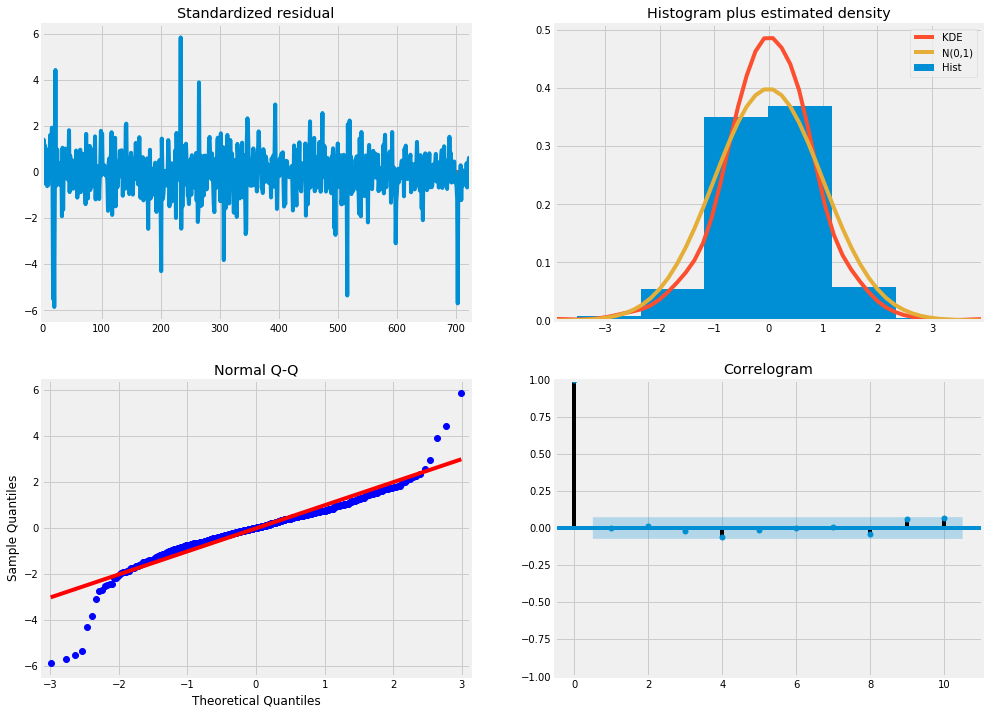

In [12]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [13]:
# create predictions
sarimax_preds = results.predict(start = results.nobs, 
                                end = results.nobs+19, 
                                exog=test.drop(columns='open_price'))

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


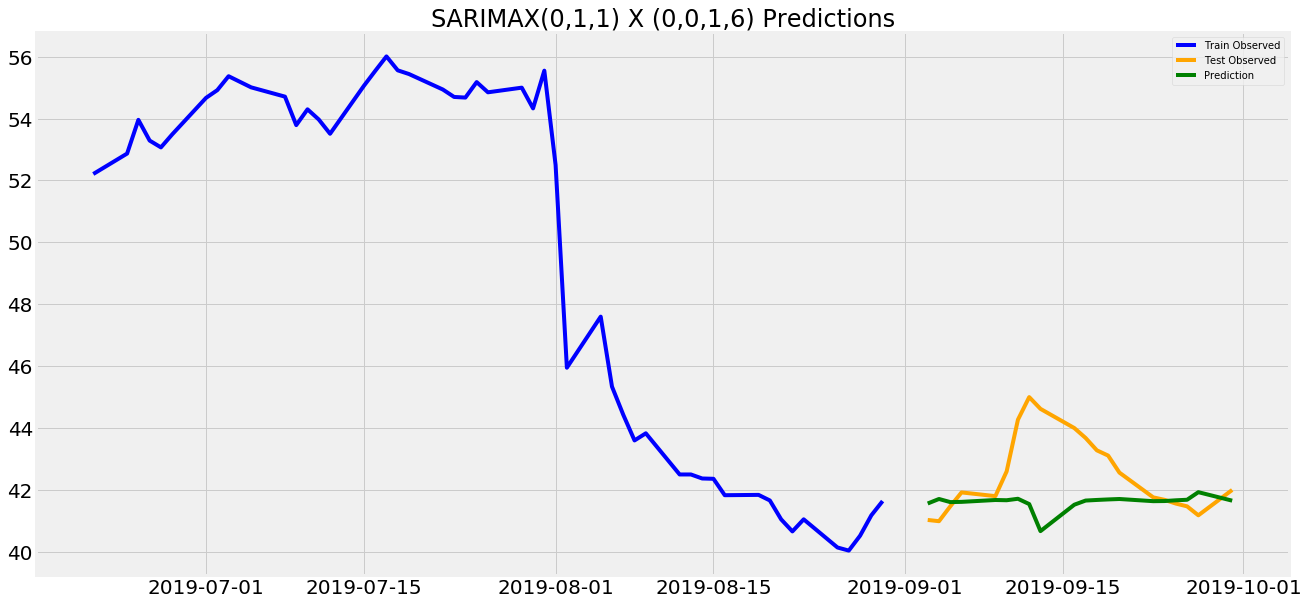

In [78]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index[-50:], pd.DataFrame(train['open_price'][-50:]), color = 'blue')

# Plot testing data.
plt.plot(test.index, pd.DataFrame(test['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test.index, pd.DataFrame(sarimax_preds), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(0,1,1) X (0,0,1,6) Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

Our predictions are really bad, they are almost the opposite to the observed data.

In [15]:
# MSE
mean_squared_error(pd.DataFrame(test['open_price']), sarimax_preds)

2.608629717645921

### SARIMAX with Less Features

Instead of including all the features, I want to simplify the model by dropping some features with low correlaton to `open_price`:

Text(0.5, 1, 'Correlation Heatmap')

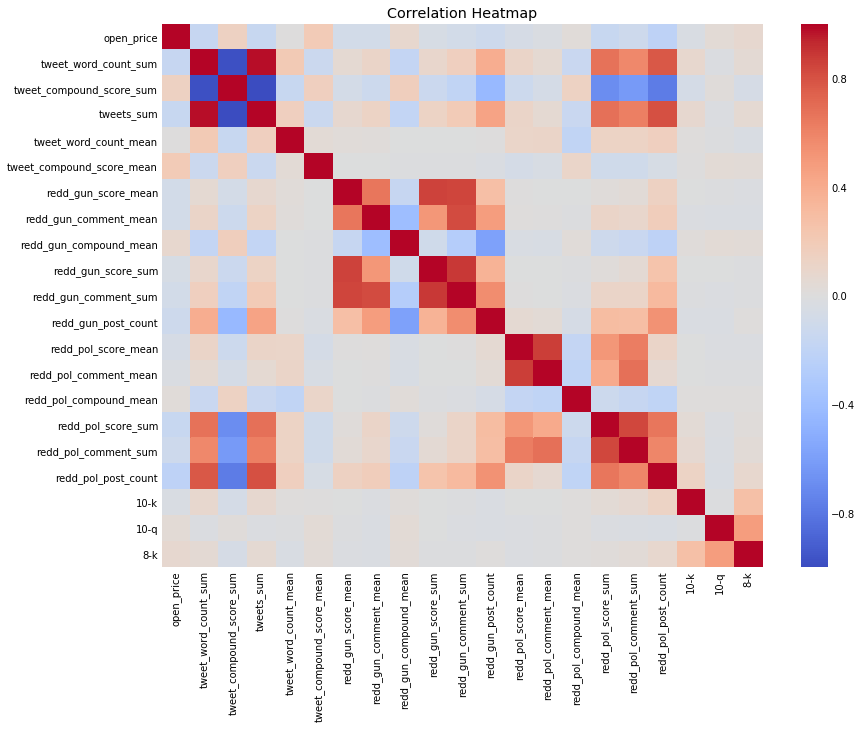

In [84]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), cmap = 'coolwarm')
plt.title('Correlation Heatmap')

In [16]:
train.corr()['open_price'].sort_values()

redd_pol_post_count         -0.214442
tweet_word_count_sum        -0.161478
redd_pol_score_sum          -0.151900
tweets_sum                  -0.151613
redd_gun_post_count         -0.113700
redd_pol_comment_sum        -0.110472
redd_gun_comment_sum        -0.082743
redd_gun_comment_mean       -0.080710
redd_gun_score_mean         -0.080237
redd_pol_score_mean         -0.059464
redd_gun_score_sum          -0.048888
10-k                        -0.032203
redd_pol_comment_mean       -0.026927
tweet_word_count_mean        0.002889
redd_pol_compound_mean       0.029383
10-q                         0.044495
8-k                          0.072419
redd_gun_compound_mean       0.081421
tweet_compound_score_sum     0.145399
tweet_compound_score_mean    0.197322
open_price                   1.000000
Name: open_price, dtype: float64

**Features can be dropped**
- 10-k                        -0.075070
- redd_gun_comment_sum        -0.034427
- redd_gun_comment_mean       -0.029288
- redd_pol_score_mean         -0.007994
- redd_pol_compound_mean      -0.004408
- redd_gun_score_sum          -0.003126
- redd_gun_score_mean          0.007457
- 10-q                         0.039278
- redd_pol_comment_mean        0.048663
- 8-k                          0.069770

In [17]:
dropping_list = ['10-k', 
                 'redd_gun_comment_sum',
                 'redd_gun_comment_mean',
                 'redd_pol_score_mean',
                 'redd_pol_compound_mean',
                 'redd_gun_score_sum',
                 'redd_gun_score_mean',
                 '10-q',
                 'redd_pol_comment_mean',
                 '8-k']

train_2 = train.drop(columns=dropping_list)
test_2 = test.drop(columns=dropping_list)

In [18]:
# gridsearching
best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_2['open_price'],
                                            train_2.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 9211.711201925315


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 9211.711201925315


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: 4891.668295356729


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: 4886.863776948343


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 7476.1197837210875


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 7585.098356018878


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: 3394.167942025716


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: 3507.4758976007643


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 5) - AIC: 4657.03496064424


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: 4678.159701781878


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 5) - AIC: 4662.146129220146
ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: 4696.035894672446


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 5) - AIC: 3396.2612109402444


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: 3508.1345594921977


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC: 3395.8562024339385


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 6) - AIC: 3509.447297695112


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 5) - AIC: 4792.527138107927


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 6) - AIC: 4792.527138107927


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 5) - AIC: 4698.084272220212


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 6) - AIC: 4677.806930061846


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC: 3200.372887318841


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 6) - AIC: 3117.085406579521


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC: 3139.815436605313


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 6) - AIC: 3083.7570516074975


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 5) - AIC: 4694.888712889742


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 6) - AIC: 4667.522761760541
ARIMA(0, 0, 1)x(1, 0, 1, 5) - AIC: 4633.966529462401


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 6) - AIC: 4628.293266771661


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 5) - AIC: 3165.61021556379


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 6) - AIC: 3100.890397098456


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC: 3141.4632552523817


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 6) - AIC: 3086.0819017920567


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC: 6389.344980510976


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC: 6389.344980510976


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC: 2288.3509884730393


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC: 2285.773965225342


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 5) - AIC: 6842.849230886641


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 6) - AIC: 6837.538159623461


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC: 2336.3043370746236


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 6) - AIC: 2395.5644198914933


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 5) - AIC: 2291.439969591945


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC: 2288.297830311853


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 5) - AIC: 2290.552609052869


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC: 2287.490238781643


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 5) - AIC: 2528.3221059813495


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC: 2555.9437150186686


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 5) - AIC: 2355.8375153172574


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC: 2421.15700939213


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC: 2298.379645667762


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC: 2298.379645667762


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 5) - AIC: 2287.537007899083


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC: 2285.1909049015585


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 5) - AIC: 2783.202448519931


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 6) - AIC: 2784.905918293718


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC: 2441.4697460862876


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC: 2473.308790364588


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 5) - AIC: 2293.2070266408464


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC: 2290.0896194353977


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 5) - AIC: 2289.434987144392


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC: 2286.605299760815


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 5) - AIC: 2567.644387699037


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 6) - AIC: 2587.018879751129


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 5) - AIC: 2454.089240231107


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 6) - AIC: 2491.3199746131786


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 5) - AIC: 4401.717431064875


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 6) - AIC: 4401.717431064875


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 5) - AIC: 4413.830061323699
ARIMA(1, 0, 0)x(0, 0, 1, 6) - AIC: 4405.4587216460895


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 5) - AIC: 2766.9759591596235


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 6) - AIC: 2777.2106155854963


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 5) - AIC: 2699.1630169856235


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 6) - AIC: 2714.749504930412
ARIMA(1, 0, 0)x(1, 0, 0, 5) - AIC: 4623.550285508749


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 6) - AIC: 4601.3685070610445
ARIMA(1, 0, 0)x(1, 0, 1, 5) - AIC: 4429.150330377164


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 6) - AIC: 4418.723533404511


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 5) - AIC: 2721.6125241344844


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 6) - AIC: 2749.6765422378576


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 5) - AIC: 2701.022504648243


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 6) - AIC: 2716.8568986571568


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 5) - AIC: 4311.243828002227


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 6) - AIC: 4311.243828002227
ARIMA(1, 0, 1)x(0, 0, 1, 5) - AIC: 4345.260351914065


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 6) - AIC: 4336.974284801723


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 5) - AIC: 2764.20187256145


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 6) - AIC: 2776.1650203951313


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 5) - AIC: 2697.677496289769


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 6) - AIC: 2711.591988492482


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 5) - AIC: 4592.197383455587


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 6) - AIC: 4563.7177915795655


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 5) - AIC: 4376.9995073572145


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 6) - AIC: 4356.238337751207


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 5) - AIC: 2722.637406055952


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 6) - AIC: 2751.6993364580076


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 5) - AIC: 2699.559935207923


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 6) - AIC: 2713.5967038060426


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 5) - AIC: 2300.517115833716


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 6) - AIC: 2300.517115833716


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 5) - AIC: 2290.098629953662


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 6) - AIC: 2287.5385959839887


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 5) - AIC: 2786.1806662082045


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 6) - AIC: 2787.7914175561773


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 5) - AIC: 2443.790928839403


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 6) - AIC: 2475.543857601466


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 5) - AIC: 2290.092637508493


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 6) - AIC: 2287.50690709629


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 5) - AIC: 2292.0944269137804


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 6) - AIC: 2288.998192449467


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 5) - AIC: 2563.8232462875985


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 6) - AIC: 2582.3747678541686


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 5) - AIC: 2456.631162900339


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 6) - AIC: 2493.8302466205314


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 5) - AIC: 2300.333754955939


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 6) - AIC: 2300.333754955939


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 5) - AIC: 2289.5089374177824


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 6) - AIC: 2287.3533823051484


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 5) - AIC: 2791.988106114615


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 6) - AIC: 2786.30735155045


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 5) - AIC: 2446.0324617953174


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 6) - AIC: 2474.982482349408


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 5) - AIC: 2291.9270574561633


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 6) - AIC: 2289.5710039785927


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 5) - AIC: 2291.268234391403


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6) - AIC: 2288.7570943216724


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 5) - AIC: 2570.482729602159


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 6) - AIC: 2584.5117371668694


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 5) - AIC: 2458.544925870825


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 6) - AIC: 2492.953804795112
Best AIC score is: 2285.1909049015585
ARIMA params is: (0, 1, 1)
SARIMA param is: (0, 0, 1, 6)


In [19]:
# fitting the model
mod = sm.tsa.statespace.SARIMAX(endog=train_2['open_price'],
                                exog=train_2.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                        open_price   No. Observations:                  733
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood               -1129.595
Date:                           Thu, 05 Dec 2019   AIC                           2285.191
Time:                                   06:11:34   BIC                           2344.793
Sample:                                        0   HQIC                          2308.195
                                           - 733                                         
Covariance Type:                             opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum       2.658e-07   1.27e-06      0.210      0.834   -2.22e-06    2.75e-0

**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

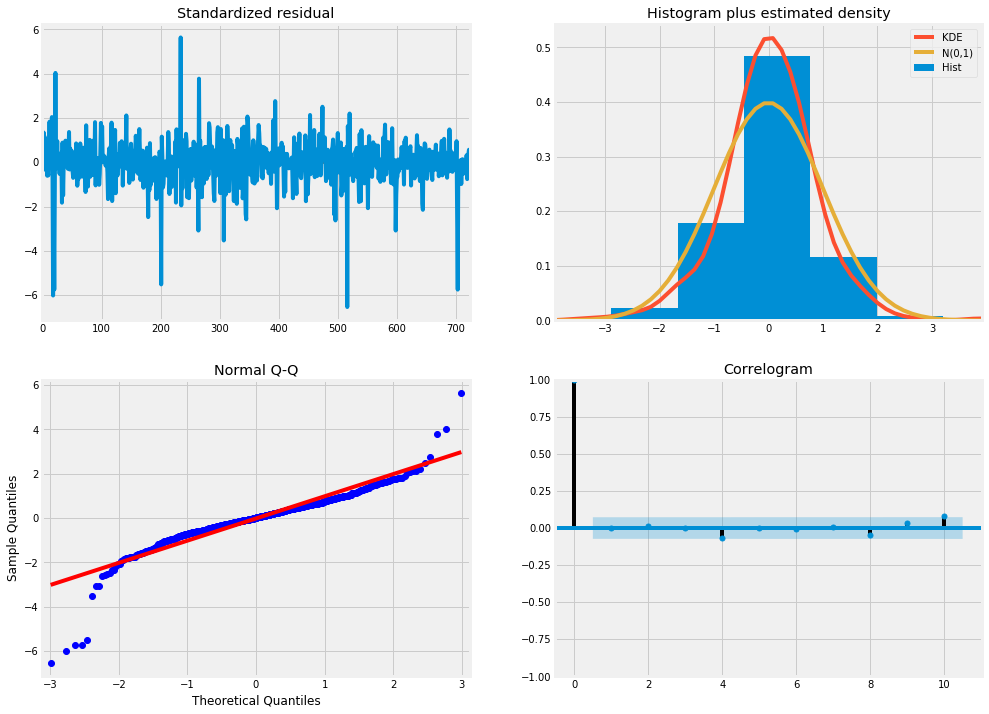

In [20]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [21]:
sarimax_preds_2 = results.predict(start = results.nobs, 
                               end = results.nobs+19, 
                               exog=test_2.drop(columns='open_price'),
                               dynamic=False)

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


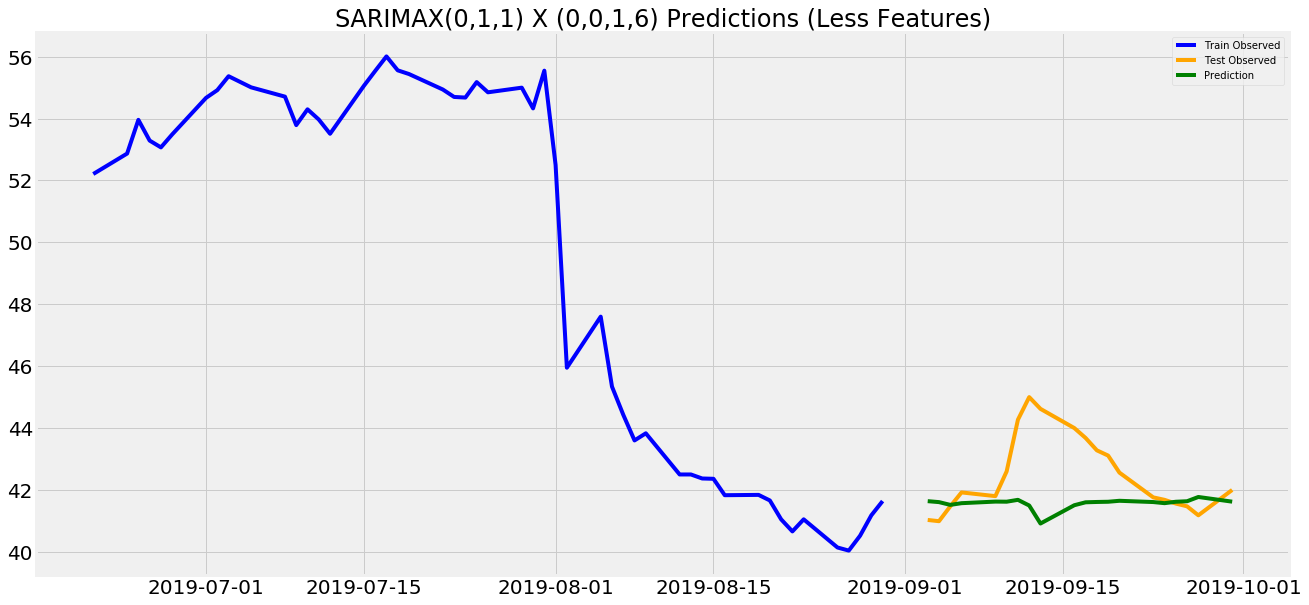

In [22]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train_2.index[-50:], pd.DataFrame(train_2['open_price'][-50:]), color = 'blue')

# Plot testing data.
plt.plot(test_2.index, pd.DataFrame(test_2['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test_2.index, pd.DataFrame(sarimax_preds_2), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(0,1,1) X (0,0,1,6) Predictions (Less Features)', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [23]:
# MSE
mean_squared_error(pd.DataFrame(test_2['open_price']), sarimax_preds_2)

2.5756278354362507

### SARIMAX on Percentage Difference

Since above models are not performing well. I decided to try to predict the percentage change of the stock open price:

In [24]:
train_3 = df_final['2016':'2019-8'].copy()
test_3 = df_final['2019-9'].copy()

train_3['open_price'] = train_3['open_price'].pct_change()
test_3['open_price'] = test_3['open_price'].pct_change()

train_3.dropna(inplace=True)
test_3.dropna(inplace=True)

In [25]:
p = d = q = range(0, 2)
s = range(5,7)
pdq = list(itertools.product(p, d, q))
pdqs = list(itertools.product(p, d, q, s))
seasonal_pdqs = [(x[0], x[1], x[2], x[3]) for x in pdqs]

In [26]:
# gridsearching

best_aic = 10000
best_param = (0, 0, 0)
best_param_season = (0, 0, 0, 0)

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_3['open_price'],
                                            train_3.drop(columns='open_price'),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            current_aic = results.aic
            if current_aic < best_aic:
                best_aic = current_aic
                best_param = param
                best_param_season = param_seasonal
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(f'Best AIC score is: {best_aic}')
print(f'ARIMA params is: {best_param}')
print(f'SARIMA param is: {best_param_season}')

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 5) - AIC: 551.355080556805


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 551.355080556805


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 5) - AIC: -3510.4938039505964


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: -3505.2456572796004


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 5) - AIC: 1035.7929535815247


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 1020.2021641237523


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 5) - AIC: -3402.3345870567246


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: -3329.585819066334


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 5) - AIC: -3515.5538731833158


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: -3510.729613184212


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 5) - AIC: -3508.635721057238


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: -3503.1668791426537


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 5) - AIC: -3232.258849866067


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: -3189.9003539464948


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 5) - AIC: -3386.206443360596


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 6) - AIC: -3317.6913740081554


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 5) - AIC: -3531.4460539785105


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 6) - AIC: -3531.4460539785105


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 5) - AIC: -3503.1847109836626


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 6) - AIC: -3497.6478326491215


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 5) - AIC: -3015.6104989656733


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 6) - AIC: -3024.348640269529


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 5) - AIC: -3301.5055322221383


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 6) - AIC: -3259.5352885329567


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 5) - AIC: -3513.663381077243


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 6) - AIC: -3508.829341072199


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 5) - AIC: -3501.369957042271


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 6) - AIC: -3495.567493583843


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 5) - AIC: -3197.048659221153


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 6) - AIC: -3166.2204800328755


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 5) - AIC: -3290.541342698013


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 6) - AIC: -3250.6370586907183


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 5) - AIC: 1014.1171694789168


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC: 1014.1171694789168


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 5) - AIC: -3046.4696271613157


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC: -3041.55441023544


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 5) - AIC: 1481.9342554651394


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 6) - AIC: 1498.4677890640885


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 5) - AIC: -2927.2479964273816


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 6) - AIC: -2845.6869020627823


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 5) - AIC: -3050.473490313915


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC: -3046.3634474611504


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 5) - AIC: -3044.4629774672458


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC: -3039.4459723754553


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 5) - AIC: -2763.278985421177


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC: -2734.111691451416


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 5) - AIC: -2875.0832807373854


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC: -2793.693875677295


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 5) - AIC: -3368.906274572919


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC: -3368.906274572919


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 5) - AIC: -3342.241670843823


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC: -3338.532344003096


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 5) - AIC: -2819.229799609373


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 6) - AIC: -2829.996927880188


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 5) - AIC: -3106.4826967425597


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC: -3067.1374057604457


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 5) - AIC: -3352.3985504834436


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC: -3348.744417868587


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 5) - AIC: -3340.26954226426


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC: -3336.4919067256005


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 5) - AIC: -3005.7143359149304


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 6) - AIC: -2980.2174350886685


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 5) - AIC: -3072.4521301193718


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 6) - AIC: -3018.5645838712535


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 5) - AIC: -3537.326091385207


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 6) - AIC: -3537.326091385207


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 5) - AIC: -3508.6328210905594


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 6) - AIC: -3503.3842697583605


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 5) - AIC: -3020.618674176955


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 6) - AIC: -3029.538882270951


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 5) - AIC: -3307.382652568559


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 6) - AIC: -3265.5742294972833


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 5) - AIC: -3508.6479322044456


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 6) - AIC: -3503.3942579865484


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 5) - AIC: -3506.7844103218627


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 6) - AIC: -3501.3030314714188


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 5) - AIC: -3192.8243859976983


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 6) - AIC: -3162.898900438472


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 5) - AIC: -3296.1259678284714


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 6) - AIC: -3256.255235371162


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 5) - AIC: -3528.901256661793


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 6) - AIC: -3528.901256661793


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 5) - AIC: -3500.3365219643824


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 6) - AIC: -3495.0648382543936


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 5) - AIC: -2588.2000776047366


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 6) - AIC: -3021.2565909172654


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 5) - AIC: -2881.782642495515


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 6) - AIC: -3257.6576501066306


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 5) - AIC: -3506.158624254713


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 6) - AIC: -3500.542510916808


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 5) - AIC: -3498.6568422780656


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 6) - AIC: -3492.9933572835116


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 5) - AIC: -2769.3576515740974


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 6) - AIC: -3159.4986752129817


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 5) - AIC: -2870.5163765916022


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 6) - AIC: -3247.7474603160185


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 5) - AIC: -3241.0348993175126


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 6) - AIC: -3241.0348993175126


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 5) - AIC: -3218.010901199821


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 6) - AIC: -3213.1741518676736


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 5) - AIC: -2727.866844348334


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 6) - AIC: -2740.940363076279


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 5) - AIC: -3016.554490126944


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 6) - AIC: -2974.649490718697


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 5) - AIC: -3218.1580619838714


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 6) - AIC: -3212.4221449776696


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 5) - AIC: -3215.975081384322


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 6) - AIC: -3211.1155382396555


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 5) - AIC: -2906.128523952312


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 6) - AIC: -2874.7133406749435


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 5) - AIC: -2980.3511032197025


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 6) - AIC: -2917.6819639550267


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 5) - AIC: -3373.3775825945168


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 6) - AIC: -3373.3775825945168


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 5) - AIC: -3346.6547927894044


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 6) - AIC: -3342.864406661363


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 5) - AIC: -2821.760828044933


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 6) - AIC: -2815.611903518471


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 5) - AIC: -3107.1357888280663


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 6) - AIC: -3055.2125632736406


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 5) - AIC: -3351.584312615505


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 6) - AIC: -3348.655497892713


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 5) - AIC: -3344.680649823577


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6) - AIC: -3340.828565465925


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 5) - AIC: -3002.056977404823


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 6) - AIC: -2961.847112066111


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 5) - AIC: -3072.99848426928


/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 6) - AIC: -3004.0624843723836
Best AIC score is: -3537.326091385207
ARIMA params is: (1, 0, 0)
SARIMA param is: (0, 0, 0, 5)


In [27]:
# fitting the model
mod = sm.tsa.statespace.SARIMAX(endog=train_3['open_price'],
                                exog=train_3.drop(columns='open_price'),
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                        open_price   No. Observations:                  732
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood                1692.266
Date:                           Thu, 05 Dec 2019   AIC                          -3338.532
Time:                                   06:20:16   BIC                          -3233.114
Sample:                                        0   HQIC                         -3297.843
                                           - 732                                         
Covariance Type:                             opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
tweet_word_count_sum      -1.644e-09   2.85e-08     -0.058      0.954   -5.75e-08    5.42e-0

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**As we can see, the p-value for all features are pretty high. We can conclude this model is performing poorly.**

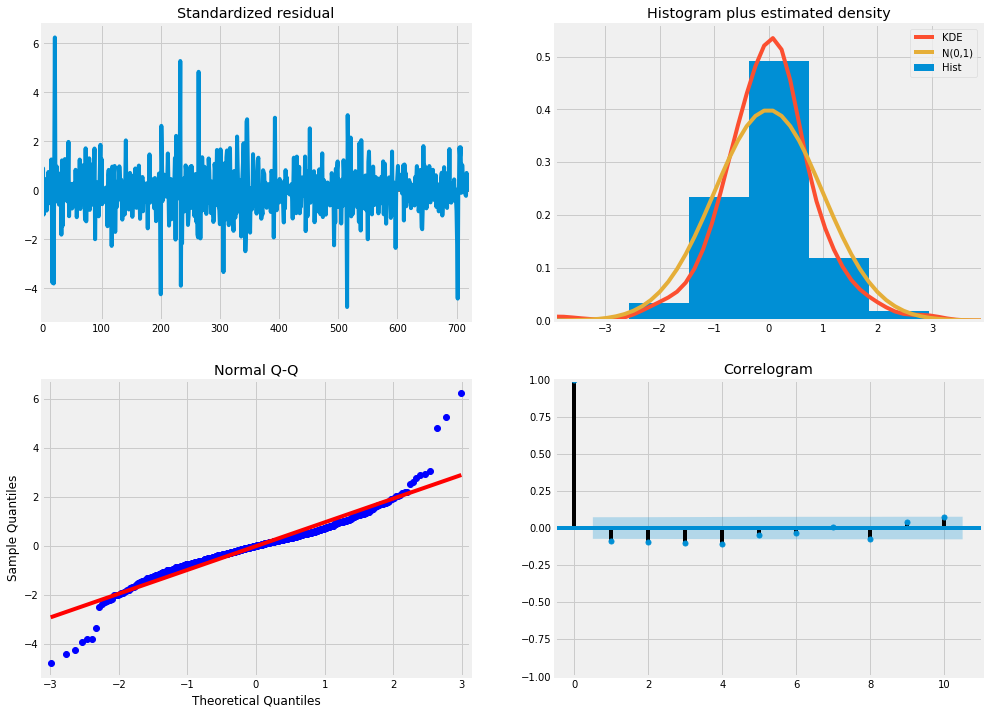

In [28]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**The above plot shows that the residuals of our model are not normally distributed well. We should improve on our model. Our ultimate goal is to have uncorrelated residuals and normally distributed residuals.**

In [29]:
sarimax_preds_3 = results.predict(start = results.nobs, 
                                end = results.nobs+18, 
                                exog=test_3.drop(columns='open_price'))

/Users/jackwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


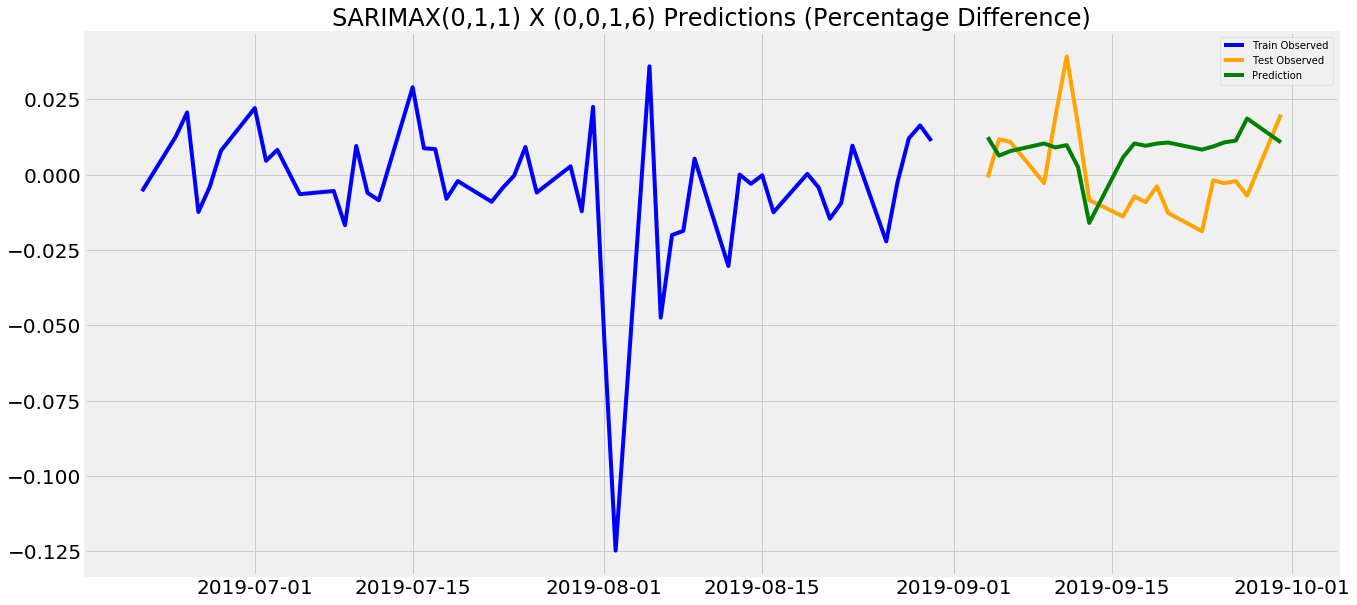

In [85]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train_3.index[-50:], pd.DataFrame(train_3['open_price'][-50:]), color = 'blue')

# Plot testing data.
plt.plot(test_3.index, pd.DataFrame(test_3['open_price']), color = 'orange')

# Plot predicted test values.
plt.plot(test_3.index, pd.DataFrame(sarimax_preds_3), color = 'green')

# Set label.
plt.title(label = 'SARIMAX(0,1,1) X (0,0,1,6) Predictions (Percentage Difference)', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [31]:
# MSE
mean_squared_error(pd.DataFrame(test_3['open_price']), sarimax_preds_3)

0.00028268797851903343

### Neural Network - RNN Classifier

SARIMAX did not work well - try neural networks!

In [32]:
df = df_final.copy()
df['open_price'] = df['open_price'].pct_change()
df.dropna(inplace=True)
df['Target'] = (df['open_price'] >= 0).astype(int)

In [33]:
# Create X and y
X = df.drop(columns='Target')
y = df['Target'].values

In [34]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=20)

In [35]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns='open_price'))
X_test_sc = ss.transform(X_test.drop(columns='open_price'))

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

In [36]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 3,
                                      batch_size = 128)

In [37]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 3,
                                     batch_size = 128)

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

In [38]:
# Design RNN
model = Sequential()

# no activation fn for RNNs
model.add(GRU(20,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(3, 20), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

# 1st dense layer
model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2))


# 2nd dense layer
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2))

# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation='sigmoid'))

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.005),
              metrics=['accuracy'])

In [40]:
hist = model.fit_generator(train_sequences,
                    epochs=100,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/100
6/6 - 1s - loss: 0.6956 - accuracy: 0.4938 - val_loss: 0.7229 - val_accuracy: 0.3529
Epoch 2/100
6/6 - 1s - loss: 0.6954 - accuracy: 0.5089 - val_loss: 0.7128 - val_accuracy: 0.2941
Epoch 3/100
6/6 - 1s - loss: 0.6923 - accuracy: 0.5117 - val_loss: 0.6984 - val_accuracy: 0.2941
Epoch 4/100
6/6 - 1s - loss: 0.6872 - accuracy: 0.5748 - val_loss: 0.6839 - val_accuracy: 0.4706
Epoch 5/100
6/6 - 1s - loss: 0.6860 - accuracy: 0.5405 - val_loss: 0.6700 - val_accuracy: 0.7059
Epoch 6/100
6/6 - 1s - loss: 0.6879 - accuracy: 0.5652 - val_loss: 0.6551 - val_accuracy: 0.8824
Epoch 7/100
6/6 - 1s - loss: 0.6854 - accuracy: 0.5418 - val_loss: 0.6293 - val_accuracy: 0.7647
Epoch 8/100
6/6 - 1s - loss: 0.6779 - accuracy: 0.5679 - val_loss: 0.6583 - val_accuracy: 0.5882
Epoch 9/100
6/6 - 1s - loss: 0.6776 - accuracy: 0.5706 - val_loss: 0.6054 - val_accuracy: 0.7647
Epoch 10/100
6/6 - 1s - loss: 0.6899 - accuracy: 0.5267 - val_loss: 0.6114 - val_accuracy: 0.7647
Epoch 11/100
6/6 - 1s - loss:

Epoch 85/100
6/6 - 1s - loss: 0.4623 - accuracy: 0.7298 - val_loss: 1.0043 - val_accuracy: 0.7647
Epoch 86/100
6/6 - 1s - loss: 0.4731 - accuracy: 0.7394 - val_loss: 1.1013 - val_accuracy: 0.6471
Epoch 87/100
6/6 - 1s - loss: 0.4527 - accuracy: 0.7119 - val_loss: 1.0799 - val_accuracy: 0.4706
Epoch 88/100
6/6 - 1s - loss: 0.4527 - accuracy: 0.7353 - val_loss: 1.1291 - val_accuracy: 0.5294
Epoch 89/100
6/6 - 1s - loss: 0.4783 - accuracy: 0.7353 - val_loss: 1.1672 - val_accuracy: 0.5882
Epoch 90/100
6/6 - 1s - loss: 0.4553 - accuracy: 0.7421 - val_loss: 1.1273 - val_accuracy: 0.5294
Epoch 91/100
6/6 - 1s - loss: 0.4669 - accuracy: 0.7503 - val_loss: 1.1682 - val_accuracy: 0.5882
Epoch 92/100
6/6 - 1s - loss: 0.4580 - accuracy: 0.7421 - val_loss: 1.1919 - val_accuracy: 0.5882
Epoch 93/100
6/6 - 1s - loss: 0.4695 - accuracy: 0.7160 - val_loss: 1.2304 - val_accuracy: 0.4706
Epoch 94/100
6/6 - 1s - loss: 0.4474 - accuracy: 0.7476 - val_loss: 1.1415 - val_accuracy: 0.4118
Epoch 95/100
6/6 - 1

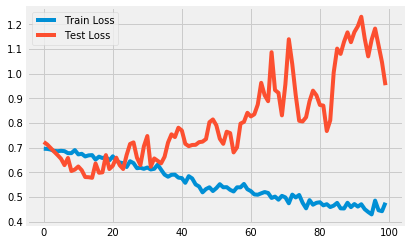

In [41]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

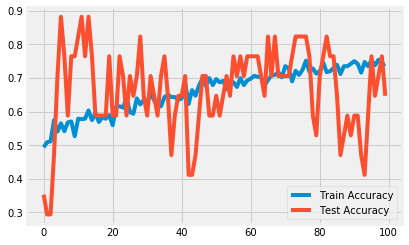

In [42]:
# Plot out our train/test accuracy curves
plt.plot(hist.history['accuracy'], label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'], label = "Test Accuracy")
plt.legend();

In [43]:
# predicted classes
model.predict_classes(test_sequences[0][0])

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

In [44]:
model.predict_proba(test_sequences[0][0])

array([[0.01347974],
       [0.9885477 ],
       [0.84798014],
       [0.11197925],
       [0.72997844],
       [0.2851298 ],
       [0.00481144],
       [0.11871862],
       [0.09462395],
       [0.00928643],
       [0.50251573],
       [0.44770652],
       [0.49253708],
       [0.5250747 ],
       [0.49681282],
       [0.5106884 ],
       [0.9369031 ]], dtype=float32)

### Neural Network - RNN Regressor

In [45]:
df = df_final.copy()
df['open_price'] = df['open_price'].pct_change()
df.dropna(inplace=True)

In [46]:
# Create X and y
X = df.drop(columns='open_price')
y = df['open_price'].values
y

array([-0.00553729, -0.00243604, -0.01622187, -0.00673762, -0.00571223,
        0.01974862, -0.01408449,  0.00892857,  0.0123894 ,  0.        ,
        0.02797199, -0.00680267,  0.02054788, -0.00335564,  0.01010098,
        0.01166668, -0.01070843, -0.00999164, -0.01093359,  0.00935372,
        0.03622581,  0.00406504,  0.00404858,  0.00887095,  0.03677057,
       -0.00462598, -0.10689389, -0.02775374, -0.11685993, -0.02828287,
        0.09979219, -0.00756147, -0.00285718,  0.02101247, -0.00187096,
       -0.00656041,  0.00188675, -0.0103578 , -0.00285437,  0.00858771,
        0.00946074, -0.03748829,  0.02044799, -0.03339695,  0.        ,
       -0.00197439, -0.0039565 ,  0.02383319,  0.00193992,  0.00774438,
       -0.00480307, -0.00579149,  0.00679608,  0.029894  , -0.00749067,
        0.01415094, -0.00651159,  0.00187262,  0.01121492, -0.00739366,
       -0.01582873, -0.00189211,  0.00284364,  0.01039696, -0.0056127 ,
        0.01787387,  0.00369688, -0.02209947, -0.0094162 , -0.01

In [47]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=20)

In [48]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [49]:
X_train.shape

(732, 20)

In [50]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 3,
                                      batch_size = 128)

In [51]:
train_sequences[0][0].shape

(128, 3, 20)

In [52]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 3,
                                     batch_size = 128)

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 2 hidden `Dense` layers
- 1 `Dense` output layer

In [53]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNNs
model.add(GRU(21,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(3, 20), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2)) 


#
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2)) 

#
model.add(Dense(8,
                activation='relu'))
model.add(Dropout(.2)) 


# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation=None))

In [54]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.005),
              metrics=['mean_squared_error'])

In [55]:
hist = model.fit_generator(train_sequences,
                    epochs=50,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/50
6/6 - 1s - loss: 0.0022 - mean_squared_error: 0.0021 - val_loss: 3.7564e-04 - val_mean_squared_error: 3.7564e-04
Epoch 2/50
6/6 - 1s - loss: 6.3931e-04 - mean_squared_error: 6.4514e-04 - val_loss: 1.9128e-04 - val_mean_squared_error: 1.9128e-04
Epoch 3/50
6/6 - 1s - loss: 5.1965e-04 - mean_squared_error: 5.2151e-04 - val_loss: 2.2587e-04 - val_mean_squared_error: 2.2587e-04
Epoch 4/50
6/6 - 1s - loss: 4.7912e-04 - mean_squared_error: 4.8026e-04 - val_loss: 2.1406e-04 - val_mean_squared_error: 2.1406e-04
Epoch 5/50
6/6 - 1s - loss: 4.5899e-04 - mean_squared_error: 4.6200e-04 - val_loss: 2.2637e-04 - val_mean_squared_error: 2.2637e-04
Epoch 6/50
6/6 - 1s - loss: 4.5876e-04 - mean_squared_error: 4.6155e-04 - val_loss: 2.1927e-04 - val_mean_squared_error: 2.1927e-04
Epoch 7/50
6/6 - 1s - loss: 4.6356e-04 - mean_squared_error: 4.6468e-04 - val_loss: 2.1668e-04 - val_mean_squared_error: 2.1668e-04
Epoch 8/50
6/6 - 1s - loss: 4.5457e-04 - mean_squared_error: 4.5597e-04 - val_loss: 

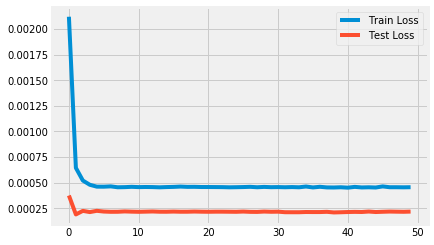

In [56]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

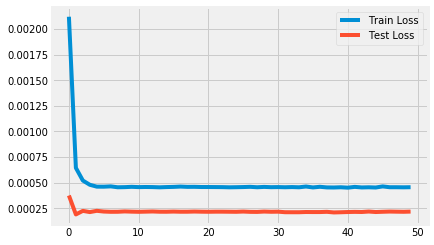

In [57]:
plt.plot(hist.history['mean_squared_error'], label = "Train Loss")
plt.plot(hist.history['val_mean_squared_error'], label = "Test Loss")
plt.legend();

In [58]:
preds = model.predict(test_sequences[0][0])

In [59]:
preds

array([[-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528],
       [-0.00062528]], dtype=float32)

In [86]:
# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train['open_price']), color = 'blue')

# Plot testing data.
plt.plot(pd.DataFrame(y_test[3:]).index, pd.DataFrame(y_test[3:]), color = 'orange')

# Plot predicted test values.
plt.plot(pd.DataFrame(preds).index, pd.DataFrame(preds), color = 'green')

# Set label.
plt.title(label = 'RNN Predictions', fontsize=24)

# Set legend.
plt.legend(['Train Observed', 'Test Observed', 'Prediction'])

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

ValueError: view limit minimum -36865.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11276bd90> (for post_execute):


ValueError: view limit minimum -36865.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36865.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

### Final RNN Classifier Model for Flask

In [61]:
df = df_final.copy().iloc[:,0:6]
df['open_price'] = df['open_price'].pct_change()
df.dropna(inplace=True)
df['Target'] = (df['open_price'] >= 0).astype(int)

In [62]:
# Create X and y
X = df.drop(columns='Target')
y = df['Target'].values

In [63]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size=23)

In [64]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns='open_price'))
X_test_sc = ss.transform(X_test.drop(columns='open_price'))

In [65]:
# export scaler
joblib.dump(ss, "../assets/scaler.save")

['../assets/scaler.save']

In [66]:
# test the scaler
scaler = joblib.load("../assets/scaler.save") 
scaler.transform(X_test.drop(columns='open_price'))

array([[-0.0820351 ,  0.11040498, -0.10579633,  0.87093378,  0.07815265],
       [-0.12486733,  0.15637282, -0.14480464,  0.83059397,  0.61655328],
       [-0.13199435,  0.14879379, -0.14989711,  0.78742182,  0.04262577],
       [ 1.03255811, -0.93060226,  0.87603147,  1.18807165, -1.28927527],
       [ 1.04180627, -0.84121224,  0.87246674,  1.24070903, -0.59788209],
       [ 0.38911196, -0.26195295,  0.31066569,  1.10799904,  0.03457651],
       [ 0.13479311, -0.08271969,  0.07814361,  1.13070842, -0.60800973],
       [ 0.11532291, -0.05065831,  0.07814361,  0.91079515,  0.12634747],
       [ 0.20558008, -0.1564846 ,  0.17337275,  0.8102086 , -0.28301928],
       [ 0.37162272, -0.35175978,  0.3490629 ,  0.69290204, -0.74751033],
       [ 0.53173725, -0.43195553,  0.47219877,  0.8987042 , -0.27673319],
       [ 0.83741346, -0.58692537,  0.73649785,  1.0134867 ,  0.53024076],
       [ 0.2194763 , -0.13639479,  0.1577898 ,  1.0974415 , -0.17285054],
       [ 0.06324253, -0.02040074,  0.0

In [67]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train,
                                      length = 2,
                                      batch_size = 128)

In [68]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                     length = 2,
                                     batch_size = 128)

In [69]:
# Design RNN
model = Sequential()

# Don't set the activation fn for RNNs
model.add(GRU(5,
              dropout=.2, # X_sample
              recurrent_dropout=.2, # state from previous step
              input_shape=(2, 5), # implicitly setting the input layer
              return_sequences=True)) # True if the NEXT layer is RNNs

model.add(GRU(32,
              return_sequences=False)) # False if the NEXT layer is DENSE

# 1st

model.add(Dense(64,
                activation='relu'))
model.add(Dropout(.2))

# 2nd

model.add(Dense(32,
                activation='relu'))
model.add(Dropout(.2))

# For Binary classification
# 1 neuron, sigmoid activation fn
model.add(Dense(1,
                activation='sigmoid'))

In [70]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.005),
              metrics=['accuracy'])

In [71]:
hist = model.fit_generator(train_sequences,
                    epochs=50,
                    validation_data=test_sequences,
                    verbose=2)

Epoch 1/50
6/6 - 1s - loss: 0.6939 - accuracy: 0.5199 - val_loss: 0.6941 - val_accuracy: 0.3810
Epoch 2/50
6/6 - 0s - loss: 0.6925 - accuracy: 0.5103 - val_loss: 0.6987 - val_accuracy: 0.3333
Epoch 3/50
6/6 - 0s - loss: 0.6935 - accuracy: 0.5131 - val_loss: 0.6999 - val_accuracy: 0.3333
Epoch 4/50
6/6 - 0s - loss: 0.6936 - accuracy: 0.5199 - val_loss: 0.6976 - val_accuracy: 0.3333
Epoch 5/50
6/6 - 0s - loss: 0.6921 - accuracy: 0.5186 - val_loss: 0.6987 - val_accuracy: 0.3333
Epoch 6/50
6/6 - 0s - loss: 0.6932 - accuracy: 0.5076 - val_loss: 0.6955 - val_accuracy: 0.2857
Epoch 7/50
6/6 - 0s - loss: 0.6930 - accuracy: 0.4911 - val_loss: 0.6963 - val_accuracy: 0.3333
Epoch 8/50
6/6 - 0s - loss: 0.6934 - accuracy: 0.5172 - val_loss: 0.6926 - val_accuracy: 0.5238
Epoch 9/50
6/6 - 0s - loss: 0.6931 - accuracy: 0.5296 - val_loss: 0.6938 - val_accuracy: 0.4762
Epoch 10/50
6/6 - 0s - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.6190
Epoch 11/50
6/6 - 1s - loss: 0.6925 - a

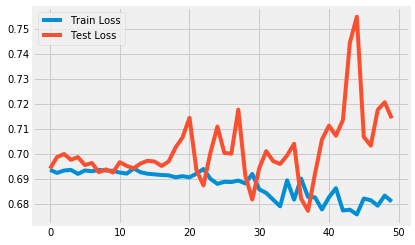

In [72]:
# Plot out our train/test loss curves

plt.plot(hist.history['loss'], label = "Train Loss")
plt.plot(hist.history['val_loss'], label = "Test Loss")
plt.legend();

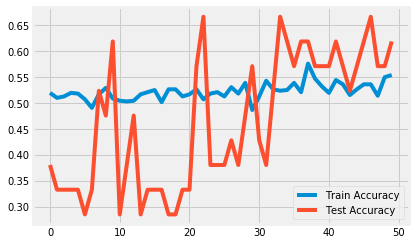

In [73]:
plt.plot(hist.history['accuracy'], label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'], label = "Test Accuracy")
plt.legend();

In [74]:
model.predict_classes(test_sequences[0][0])

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [75]:
model.predict_proba(test_sequences[0][0])

array([[0.49067292],
       [0.49148962],
       [0.28520158],
       [0.34709212],
       [0.83830917],
       [0.5014261 ],
       [0.45980048],
       [0.4683137 ],
       [0.429595  ],
       [0.4049245 ],
       [0.38147295],
       [0.8759254 ],
       [0.4854594 ],
       [0.41831604],
       [0.46734014],
       [0.4908434 ],
       [0.49595618],
       [0.46398374],
       [0.49421456],
       [0.4941128 ],
       [0.49999774]], dtype=float32)

In [76]:
# Export the model to h5 file

model.save('../assets/final_model.h5')

### Conclusion

The best SARIMAX model with the best AIC score is (0, 1, 1) X (0, 0, 1, 6). It is more intuitive to use 5 as our seasonal component because there are 5 trading days in a week, however, S = 6 has a better AIC score so we ended up using it as our final model. The predictions of our final SARIMAX model are off, this is disappointed because I have included so many X variables to help the model. Instead of predicting the stock open price, I have tried to predict the stock open price percentage change using SARIMAX model as well. The model performed as bad as predicting the open price directly.

Besides SARIMAX models, I have used neural networks to predict the stock price. And the result did not go well. As a consequence, I decided to change my original goal; now I just want to predict if the stock price would go up or go down the next trade day based on public opinion on gun control. The good news is that the classification model I built using neural network actually performed better than other ones. So I implemented this model to a Flask app.

### Improvements

1. More data may help. I built the model on data from 2016 October - 2019 October because scraping Twitter data took a lot of time. So I would like to see how much the models will improve if we have more data.
2. More useful exogeous variables. I have included 20 features already, but some of them are not helping the model. It seems like the financial reports 10Q, 10k, and 8K don't help much.
3. Better models. I did not dig into the popular neural network models due to time limitation. I will definitely check out [LSTM](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and some other models.

### References

- [Yahoo Finance](https://finance.yahoo.com/quote/RGR/history?p=RGR)
- [SEC](https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000095029&type=&dateb=&owner=exclude&count=100)
- [twitter](https://twitter.com/)
- [twitterscraper](https://github.com/taspinar/twitterscraper)
- [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
- [How to Scrap Reddit using pushshift.io via Python](https://medium.com/@pasdan/how-to-scrap-reddit-using-pushshift-io-via-python-a3ebcc9b83f4)
- [List of mass shootings in the United States](https://en.wikipedia.org/wiki/List_of_mass_shootings_in_the_United_States)
- [Bug in ARIMA predict(): ValueError: Must provide freq argument if no data is supplied #3534](https://github.com/statsmodels/statsmodels/issues/3534)
- [Using AIC to Test ARIMA Models](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)